In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import gc
import sys
from tifffile import TiffFile
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!mkdir /kaggle/temp

In [3]:
df = pd.read_csv("../input/mayo-jpg-dataset-4x-downsampled/train.csv")
df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [4]:
df["intlabel"] = df.label.apply(lambda x: int(x=="CE"))
df.head()

,image_id,center_id,patient_id,image_num,label,intlabel
0,006388_0,11,006388,0,CE,1
1,008e5c_0,11,008e5c,0,CE,1
2,00c058_0,11,00c058,0,LAA,0
3,01adc5_0,11,01adc5,0,LAA,0
4,026c97_0,4,026c97,0,CE,1


In [5]:
# 切出し画像バッチのサイズ
DEPTH = 128
# 切出し画像バッチの画素数
RESOLUTION = 4
IMSIZE = 128
# NN内のステージで選択する切出し画像の数
SELECT = [64, 32, 12, 6, 4]

In [6]:
# 学習時と評価時のバッチサイズ
BATCH_SIZE = 2
BATCH_SIZE_VALID = 2
DEPTH_PRETRAIN = 4
# データの読み込みスレッドの数
NUM_WORKERS = 2
# 試行時の学習エポック数
NUM_EPOCHS = 5
NUM_PRETRAIN = 150
# DAするか
USE_MIXIN = True
RAND_CLOP = 0.5
DROP_PROBA = 0.03725

In [7]:
import torch
from torch import nn, utils, optim
import torch.nn.functional as F
sys.path.append("../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master")
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split

# GPUを使うかどうか
USE_DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# PyTorchの内部を決定論的に設定する
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.enabled = False

# 乱数を初期化する
np.random.seed(42)
torch.manual_seed(42)

In [8]:
def read_image(fname, scale):
    if fname.endswith(".tif"):
        try:
            sz = os.path.getsize(fname)
        except:
            return np.zeros((IMSIZE,IMSIZE,3), dtype=np.uint8)
        if(sz > 2e9):
            return np.zeros((IMSIZE,IMSIZE,3), dtype=np.uint8)
        try:
            with TiffFile(fname) as tif:
                if(sz > 5e8):
                    image = tif.asarray(out="memmap")
                else:
                    image = tif.asarray()
            if len(image.shape) == 4:
                image = image[0]
            cvimage = image[::scale,::scale,::-1]
            del image
            gc.collect()
            return np.asarray(cvimage)
        except:
            return np.zeros((IMSIZE,IMSIZE,3), dtype=np.uint8)
    else:
        image = cv2.imread(fname)
        return image[::scale,::scale,:]

In [9]:
# PyTorchの流儀でデータセットをクラスで定義する
class MyDataset:
    def __init__(self, names, targets, resolution=RESOLUTION, valid=False):
        # 初期化 Xはファイル名のリスト、yは人物が写っているかどうかのリスト
        self.names = names
        self.targets = targets
        self.valid = valid
        self.resolution = resolution

    def __len__(self):
        # データセットの長さを返す
        return len(self.names)

    def __getitem__(self, pos):
        def da(_im):
            if self.valid == False:
                r = np.random.randint(4)
                if r == 1:
                    _im = cv2.rotate(_im, cv2.ROTATE_90_CLOCKWISE)
                elif r == 2:
                    _im = cv2.rotate(_im, cv2.ROTATE_90_COUNTERCLOCKWISE)
                elif r == 3:
                    _im = cv2.rotate(_im, cv2.ROTATE_180)
                r = np.random.randint(4)
                if r == 1:
                    _im = cv2.flip(_im, 0)
                elif r == 2:
                    _im = cv2.flip(_im, 1)
                elif r == 3:
                    _im = cv2.flip(_im, -1)
                if np.random.random() < RAND_CLOP:
                    s = np.random.randint(IMSIZE//2) + IMSIZE//2 - 2
                    i = np.random.randint(IMSIZE-2) // 2
                    j = np.random.randint(IMSIZE-2) // 2
                    _im = _im[i:i+s, j:j+s, :]
                    _im = cv2.resize(_im, (IMSIZE, IMSIZE))
            return _im
        def getone(_pos):
            im = read_image(self.names[_pos], self.resolution)
            imw, imh = im.shape[1] // IMSIZE, im.shape[0] // IMSIZE
            batch = imw * imh
            im = [da(im[IMSIZE*(i//imw):IMSIZE*(i//imw)+IMSIZE,IMSIZE*(i%imw):IMSIZE*(i%imw)+IMSIZE]) for i in range(batch)]
            im = np.stack(im).astype(np.float32) / 255.5 # D,W,H,C
            mean = np.reshape(np.mean(im, axis=-1), (batch,IMSIZE*IMSIZE))
            std = np.std(mean, axis=-1)
            idx = np.argsort(std)[::-1]
            while len(idx) < DEPTH:
                idx = np.hstack([idx, idx])
            im = im[idx[:DEPTH]]
            im = im.transpose((3,0,1,2)) # C,D,W,H
            return im
        if self.valid == False and USE_MIXIN:
            im1 = getone(pos)
            pos2 = np.random.randint(len(self.names))
            while pos == pos2 or self.targets[pos] != self.targets[pos2]:
                pos2 = np.random.randint(len(self.names))
            im2 = getone(pos2)
            split = np.random.randint(im1.shape[1])
            im = im1
            im[:,split:,:,:] = im2[:,split:,:,:]
        else:
            im = getone(pos)
        if self.targets[pos] == 0:
            target = np.array([1.0, 0.0], dtype=np.float32)
        elif self.targets[pos] == 1:
            target = np.array([0.0, 1.0], dtype=np.float32)
        else:
            target = np.array([0.0, 0.0], dtype=np.float32)
        return im, target

In [10]:
# PyTorchの流儀でデータセットをクラスで定義する
def get_backgroundclot(target, batch_size):
    a = os.listdir("../input/strip-ai-background-clot/"+target)
    np.random.shuffle(a)
    a = a[:batch_size]

    im = [cv2.resize(cv2.imread("../input/strip-ai-background-clot/"+target+"/"+i), (IMSIZE,IMSIZE)) for i in a]
    im = np.stack(im).astype(np.float32) / 255.5
    im = im.transpose((3,0,1,2)) # C,D,W,H
    return im.reshape([1]+list(im.shape))

In [11]:
train_X, test_X, train_y, test_y = train_test_split(df.image_id, df.intlabel, test_size=0.15, random_state=0)
train_X = ["../input/mayo-jpg-dataset-4x-downsampled/train/"+x+".jpg" for x in list(train_X)]
train_y = list(train_y)
weight_y = sum(train_y) / len(train_y)
other = [x for x in os.listdir("../input/mayo-jpg-dataset-4x-downsampled/other/") if x.endswith(".jpg")]
train_X += ["../input/mayo-jpg-dataset-4x-downsampled/other/"+x for x in other]
train_y += [-1] * len(other)
test_X = ["../input/mayo-jpg-dataset-4x-downsampled/train/"+x+".jpg" for x in list(test_X)]
test_y = list(test_y)
weight_y, sum(test_y) / len(test_y)

(0.728125, 0.7105263157894737)

In [12]:
# 学習用と評価用にデータセットを作る
train_ds = MyDataset(train_X, train_y, resolution=RESOLUTION)
test_ds = MyDataset(test_X, test_y, resolution=RESOLUTION, valid=True)

# 複数スレッドでファイルを読み込みつつデータを取り出すDataLoaderを作る
data_loader = utils.data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
data_loader_v = utils.data.DataLoader(
    test_ds, batch_size=BATCH_SIZE_VALID, shuffle=False, num_workers=NUM_WORKERS)

In [13]:
class TopKDepth(nn.Module):
    def __init__(self, top_k, input_ch):
        super(TopKDepth, self).__init__()
        self.top_k = top_k
        self.softplus = nn.Softplus()
        self.proba = nn.Conv3d(input_ch, 1, kernel_size=(1,4,4), stride=1, padding=0, groups=1, bias=False)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(p=DROP_PROBA)

    def forward(self, input, proba):
        p1 = self.proba(input)
        p1 = torch.squeeze(p1, 1)
        p1 = self.pool(p1)
        p1 = torch.flatten(p1, start_dim=1)
        p1 = self.drop(self.softplus(p1))
        p2, i1 = torch.topk(p1, self.top_k, dim=1)
        x1 = torch.stack([input[i,:,i1[i],:,:] for i in range(input.shape[0])])
        proba = torch.stack([proba[i,i1[i]] for i in range(input.shape[0])])
        proba = proba * torch.tanh(p2)
        return x1, proba
         
class MayoNet(nn.Module):
    def __init__(self, top_k=SELECT):
        super(MayoNet, self).__init__()
        conv = enet.EfficientNet.from_name('efficientnet-b0')
        conv.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'))
        self.topk1 = TopKDepth(top_k[0], 32)
        self.topk2 = TopKDepth(top_k[1], 24)
        self.topk3 = TopKDepth(top_k[2], 40)
        self.topk4 = TopKDepth(top_k[3], 80)
        self.topk5 = TopKDepth(top_k[4], 192)
        # 必要な畳み込み層を作る
        self.conv = conv
        self.pool = nn.AdaptiveAvgPool2d(1)
        self._swish = nn.SiLU()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=320, nhead=4)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(320, 1, bias=False)

    def extract_features(self, inputs, batch_size, depth_size):
        proba = torch.ones((batch_size, depth_size)).to(USE_DEVICE)
        # Stem
        x = self._swish(self.conv._bn0(self.conv._conv_stem(inputs))) # BD, C, W, H
        x = torch.reshape(x, (batch_size, depth_size, x.shape[1], x.shape[2], x.shape[3])) # B, D, C, W, H
        x = torch.transpose(x, 1, 2) # B, C, D, W, H
        x, p1 = self.topk1(x, proba) # B, C, D, W, H
        depth_size = x.shape[2]
        x = torch.transpose(x, 1, 2) # B, D, C, W, H
        x = torch.reshape(x, (batch_size * depth_size, x.shape[2], x.shape[3], x.shape[4])) # BD, C, W, H

        # Blocks
        i = 0
        for idx, block in enumerate(self.conv._blocks):
            drop_connect_rate = self.conv._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self.conv._blocks)  # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
            i += 1
            if i == 2:
                x = torch.reshape(x, (batch_size, depth_size, x.shape[1], x.shape[2], x.shape[3])) # B, D, C, W, H
                x = torch.transpose(x, 1, 2) # B, C, D, W, H
                x, p2 = self.topk2(x, p1) # B, C, D, W, H
                depth_size = x.shape[2]
                x = torch.transpose(x, 1, 2) # B, D, C, W, H
                x = torch.reshape(x, (batch_size * depth_size, x.shape[2], x.shape[3], x.shape[4])) # BD, C, W, H
            elif i == 4:
                x = torch.reshape(x, (batch_size, depth_size, x.shape[1], x.shape[2], x.shape[3])) # B, D, C, W, H
                x = torch.transpose(x, 1, 2) # B, C, D, W, H
                x, p3 = self.topk3(x, p2) # B, C, D, W, H
                depth_size = x.shape[2]
                x = torch.transpose(x, 1, 2) # B, D, C, W, H
                x = torch.reshape(x, (batch_size * depth_size, x.shape[2], x.shape[3], x.shape[4])) # BD, C, W, H
            elif i == 6:
                x = torch.reshape(x, (batch_size, depth_size, x.shape[1], x.shape[2], x.shape[3])) # B, D, C, W, H
                x = torch.transpose(x, 1, 2) # B, C, D, W, H
                x, p4 = self.topk4(x, p3) # B, C, D, W, H
                depth_size = x.shape[2]
                x = torch.transpose(x, 1, 2) # B, D, C, W, H
                x = torch.reshape(x, (batch_size * depth_size, x.shape[2], x.shape[3], x.shape[4])) # BD, C, W, H
            elif i == 12:
                x = torch.reshape(x, (batch_size, depth_size, x.shape[1], x.shape[2], x.shape[3])) # B, D, C, W, H
                x = torch.transpose(x, 1, 2) # B, C, D, W, H
                x, p5 = self.topk5(x, p4) # B, C, D, W, H
                depth_size = x.shape[2]
                x = torch.transpose(x, 1, 2) # B, D, C, W, H
                x = torch.reshape(x, (batch_size * depth_size, x.shape[2], x.shape[3], x.shape[4])) # BD, C, W, H
        return x, p1, p2, p3, p4, p5

    def set_top_k(self, top_k, dropout=DROP_PROBA):
        self.topk1.top_k = top_k[0]
        self.topk1.drop.p = dropout
        self.topk2.top_k = top_k[1]
        self.topk2.drop.p = dropout
        self.topk3.top_k = top_k[2]
        self.topk3.drop.p = dropout
        self.topk4.top_k = top_k[3]
        self.topk4.drop.p = dropout
        self.topk5.top_k = top_k[4]
        self.topk5.drop.p = dropout

    def forward(self, input): # B, C, D, W, H
        batch_size, depth_size = input.shape[0], input.shape[2]
        p = torch.transpose(input, 1, 2) # B, D, C, W, H
        p = torch.reshape(p, (p.shape[0] * p.shape[1], p.shape[2], p.shape[3], p.shape[4])) # BD, C, W, H
        x, p1, p2, p3, p4, p5 = self.extract_features(p, batch_size, depth_size) # BD, C=320, W, H
        x = torch.flatten(self.pool(x), start_dim=1) # BD, C
        x = torch.sigmoid(self.fc(x)) # BD, C=1
        x = torch.reshape(x, (batch_size, -1)) # B, D
        prob_last = p5
        out1 = torch.mean(torch.mul(x, prob_last), dim=1, keepdim=True) # B, 1
        out2 = torch.mean(torch.mul(1.0-x, prob_last), dim=1, keepdim=True) # B, 1
        p1 = torch.mean(p1, dim=1, keepdim=False)
        p2 = torch.mean(p2, dim=1, keepdim=False)
        p3 = torch.mean(p3, dim=1, keepdim=False)
        p4 = torch.mean(p4, dim=1, keepdim=False)
        p5 = torch.mean(p5, dim=1, keepdim=False)
        output = torch.cat([out1, out2], dim=-1) # B, 2
        probability = (p1 + p2 + p3 + p4 + p5) / 5.0 # B
        return output, probability

In [14]:
model = MayoNet()
model.to(USE_DEVICE) # GPUを使うときはGPUメモリ上に乗せる
sum(p.numel() for p in model.parameters())

10470500

In [15]:
params = model.parameters()
optimizer = optim.Adam(params)
bceloss = nn.BCELoss()

def loss(pred, true):
    if true.shape[-1] == 2:
        proba = true.sum(axis=1)
        w1 = (proba * weight_y) + (1 - proba) * 0.5
        w2 = (proba * (1-weight_y)) + (1 - proba) * 0.5
        l1 = torch.pow(pred[0][:,0] - true[:,0], 4) * w1
        l2 = torch.pow(pred[0][:,1] - true[:,1], 4) * w2
        return torch.mean(l1 + l2)
    return bceloss(pred[1], true)

In [16]:
def score(pred, true):
    if true.shape[-1] == 2:
        psum = torch.sum(pred, axis=1, keepdim=True)
        pzero = (psum == 0).float()
        psum += pzero
        pred = pred / psum + pzero / 2
        pred = torch.clip(pred, 1e-15, 1.0-1e-15)
        w = true.argmax(axis=1).float().mean()
        score = torch.mul(torch.log(pred), true) * torch.tensor([w, 1-w]) / pred.shape[0]
        return -torch.sum(score)
    return -1

In [17]:
def accuracy(pred, true):
    if true.shape[-1] == 2:
        m = true.argmax(axis=1)
        n = pred.argmax(axis=1)
        p = (m*n==1).float().sum() / torch.sum(m)
        q = ((1-m)*(1-n)==1).float().sum() / torch.sum(1-m)
        return (p+q) / 2
    return -1

In [18]:
def train_one(X, y):
    model.train() # モデルを学習用に設定する

    X = X.to(USE_DEVICE) # GPUを使うときはGPUメモリ上に乗せる
    y = y.to(USE_DEVICE) # GPUを使うときはGPUメモリ上に乗せる

    # ニューラルネットワークを実行して損失値を求める
    losses = loss(model(X), y)

    # 新しいバッチ分の学習を行う
    optimizer.zero_grad() # 一つ前の勾配をクリア
    losses.backward() # 損失値を逆伝播させる
    optimizer.step() # 新しい勾配からパラメーターを更新する

    return losses

In [19]:
print("start pretrain")

pretrain_losses = []

model.set_top_k(top_k=[DEPTH_PRETRAIN]*5, dropout=0.0)
for _ in tqdm(range(NUM_PRETRAIN)):
    # 切り抜きを学習
    X = torch.Tensor(get_backgroundclot("positive", DEPTH_PRETRAIN))
    y = torch.ones([1])
    loss1 = train_one(X, y)
    X = torch.Tensor(get_backgroundclot("negative", DEPTH_PRETRAIN))
    y = torch.zeros([1])
    loss2 = train_one(X, y)
    pretrain_losses.append((loss1.detach().cpu().numpy() + loss2.detach().cpu().numpy())/2)
del loss1, loss2

start pretrain


100%|██████████| 150/150 [00:47<00:00,  3.16it/s]


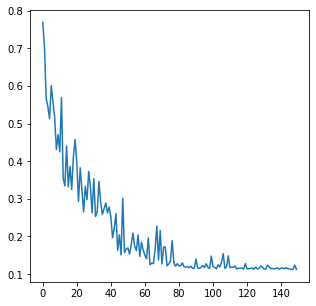

In [20]:
plt.figure(figsize=(5,5))
plt.plot(pretrain_losses)
del pretrain_losses

In [21]:
model.set_top_k(top_k=SELECT, dropout=DROP_PROBA)
model = nn.DataParallel(model)

scores_a = [] # 各エポック終了時のスコア
scores_p = [] # 各エポック終了時のスコア
losses_t = [] # 各エポック終了時の損失
losses_v = [] # 各エポック終了時の評価損失
probabilities = [] # 各エポック終了時のproba損失

# 学習ループ
for epoch in range(NUM_EPOCHS):
    total_loss = [] # 各バッチ実行時の損失値
   
    print("start train")
    model.train() # モデルを学習用に設定する
    for X, y in tqdm(data_loader): # 画像を読み込んでtensorにする
        # 画像認識を学習
        losses = train_one(X, y)
        total_loss.append(losses.detach().cpu().numpy())

    # 評価
    with torch.no_grad():
        # 評価時の損失値と正解/認識結果を入れるリスト
        total_loss_v = []
        total_proba = []
        total_preds_v = []
        total_trues_v = []
        
        model.eval() # モデルを推論用に設定する
        print("start validation")
        for X, y in tqdm(data_loader_v):
            X = X.to(USE_DEVICE) # GPUを使うときはGPUメモリ上に乗せる
            y = y.to(USE_DEVICE) # GPUを使うときはGPUメモリ上に乗せる

            res = model(X) # ニューラルネットワークの実行
            losses = loss(res, y) # 評価データの損失値

            # 損失値を保存しておく
            total_loss_v.append(losses.detach().cpu().numpy())
            total_proba.extend(torch.sum(res[0], axis=1).detach().cpu().numpy().tolist())
            total_preds_v.extend(res[0].detach().cpu().numpy().tolist())
            total_trues_v.extend(y.detach().cpu().numpy().tolist())

    # エポック終了時のスコアを求める
    total_loss = np.mean(total_loss) # 各バッチの損失の平均
    total_loss_v = np.mean(total_loss_v) # 各バッチの損失の平均
    total_proba = np.mean(total_proba) # 各バッチの損失の平均
    total_score_a = accuracy(torch.tensor(total_preds_v), torch.tensor(total_trues_v)).numpy().tolist() # スコアを求める
    total_score_p = score(torch.tensor(total_preds_v), torch.tensor(total_trues_v)).numpy().tolist() # スコアを求める
    meanclass = np.mean(np.array(total_preds_v).argmax(axis=1))
    # エポック終了時のスコアを表示する
    print(f'epoch #{epoch}: train_loss:{total_loss} valid_loss:{total_loss_v} valid_proba:{total_proba} accuracy:{total_score_a} score:{total_score_p} meanclass:{meanclass}')
    losses_t.append(total_loss)
    losses_v.append(total_loss_v)
    probabilities.append(total_proba)
    scores_a.append(total_score_a)
    scores_p.append(total_score_p)
    # エポック終了時のモデルを保存しておく
    torch.save(model.state_dict(), f'/kaggle/temp/checkpoint{epoch}.pth')
del total_loss, losses, total_loss_v, total_proba, total_preds_v, total_trues_v, res, total_score_a, total_score_p, meanclass

start train


100%|██████████| 518/518 [23:56<00:00,  2.77s/it]


start validation


100%|██████████| 57/57 [01:20<00:00,  1.41s/it]


epoch #0: train_loss:0.10664071887731552 valid_loss:0.16272978484630585 valid_proba:0.6066559092776036 accuracy:0.5875420570373535 score:0.30835458636283875 meanclass:0.5789473684210527
start train


100%|██████████| 518/518 [25:09<00:00,  2.91s/it]


start validation


100%|██████████| 57/57 [01:21<00:00,  1.43s/it]


epoch #1: train_loss:0.06294340640306473 valid_loss:0.08507252484560013 valid_proba:0.9071733668883609 accuracy:0.5370370149612427 score:0.288736492395401 meanclass:0.7192982456140351
start train


100%|██████████| 518/518 [25:02<00:00,  2.90s/it]


start validation


100%|██████████| 57/57 [01:21<00:00,  1.43s/it]


epoch #2: train_loss:0.06683001667261124 valid_loss:0.2698460519313812 valid_proba:0.3235375964525113 accuracy:0.4927048087120056 score:0.286731094121933 meanclass:0.5350877192982456
start train


100%|██████████| 518/518 [25:24<00:00,  2.94s/it]


start validation


100%|██████████| 57/57 [01:21<00:00,  1.44s/it]


epoch #3: train_loss:0.06004200875759125 valid_loss:0.24160385131835938 valid_proba:0.41604001635835774 accuracy:0.5168349742889404 score:0.2842441499233246 meanclass:0.5087719298245614
start train


100%|██████████| 518/518 [25:04<00:00,  2.90s/it]


start validation


100%|██████████| 57/57 [01:24<00:00,  1.48s/it]


epoch #4: train_loss:0.060846563428640366 valid_loss:0.26539748907089233 valid_proba:0.3869099692817366 accuracy:0.5286195278167725 score:0.28488534688949585 meanclass:0.4649122807017544


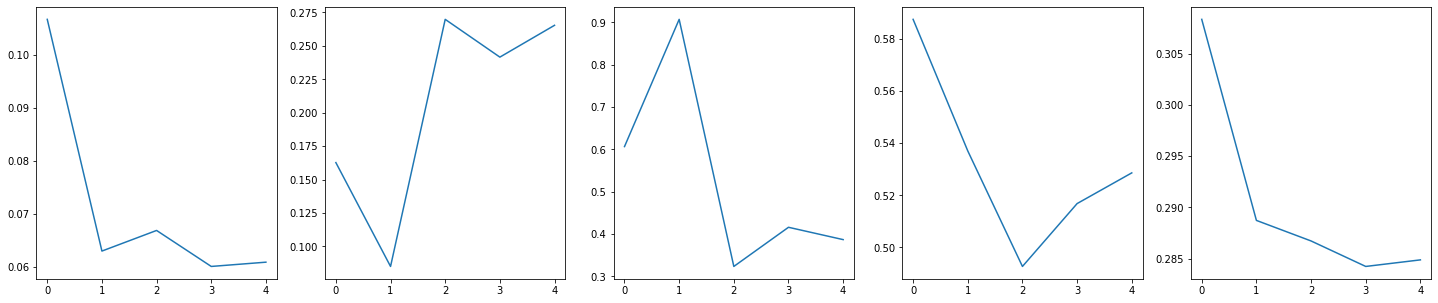

In [22]:
plt.figure(figsize=(25,5))
plt.subplot(151)
plt.plot(losses_t)
plt.subplot(152)
plt.plot(losses_v)
plt.subplot(153)
plt.plot(probabilities)
plt.subplot(154)
plt.plot(scores_a)
plt.subplot(155)
plt.plot(scores_p)

In [23]:
load_index = np.argmin(scores_p)
del scores_a, scores_p, losses_t, losses_v, probabilities

In [24]:
del df, train_X, test_X, train_y, test_y, weight_y, train_ds, test_ds, data_loader, data_loader_v, params, optimizer, bceloss
gc.collect()

62

In [25]:
model.load_state_dict(torch.load(f'/kaggle/temp/checkpoint{load_index}.pth'))

<All keys matched successfully>

In [26]:
df = pd.read_csv("../input/mayo-clinic-strip-ai/test.csv")
pred_X = ["../input/mayo-clinic-strip-ai/test/"+x+".tif" for x in list(df.image_id)]
pred_ID = list(df.patient_id)
pred_y = [-1] * len(pred_X)

pred_ds = MyDataset(pred_X, pred_y, resolution=RESOLUTION*4, valid=True) # train dataset is 4x downscaled.

data_loader_p = utils.data.DataLoader(
    pred_ds, batch_size=1, shuffle=False, num_workers=1)

In [27]:
with torch.no_grad():
    # 評価時の損失値と正解/認識結果を入れるリスト
    total_preds_p = []

    model.eval() # モデルを推論用に設定する
    print("start prediction")
    for X, y in tqdm(data_loader_p):
        X = X.to(USE_DEVICE) # GPUを使うときはGPUメモリ上に乗せる
        y = y.to(USE_DEVICE) # GPUを使うときはGPUメモリ上に乗せる

        res = model(X) # ニューラルネットワークの実行

        res = res[0].detach().cpu().numpy().tolist()
        X = X.detach().cpu().numpy().tolist()
        for r, x in zip(res, X):
            if np.all(np.array(x)==0) == True:
                total_preds_p.append([0.5,0.5])
            else:
                total_preds_p.append(r)

pred = torch.tensor(total_preds_p)
psum = torch.sum(pred, axis=1, keepdim=True)
pzero = (psum == 0).float()
psum += pzero
pred = pred / psum + pzero / 2
pred = pred.detach().numpy().tolist()

start prediction


100%|██████████| 4/4 [02:19<00:00, 34.97s/it]


In [28]:
patients = {}
for p, pred in zip(pred_ID, pred):
    if p not in patients:
        patients[p] = []
    patients[p].append(pred)
for p in list(df.patient_id):
    if p not in patients:
        patients[p] = [[0.5,0.5]]

In [29]:
parient_ids, prob_laas, prob_ces = [], [], []
for parient_id,v in patients.items():
    prob_laa = np.mean([i[0] for i in v])
    prob_ce = np.mean([i[1] for i in v])
    parient_ids.append(parient_id)
    prob_laas.append(prob_laa)
    prob_ces.append(prob_ce)
    
pd.DataFrame({"patient_id":parient_ids,"CE":prob_ces,"LAA":prob_laas}).to_csv("submission.csv", index=False)

In [30]:
!head submission.csv

patient_id,CE,LAA
006388,0.5,0.5
008e5c,0.5,0.5
00c058,0.505832314491272,0.494167685508728
01adc5,0.5,0.5
